# EGM algorithm for simpel firm problem with 1 endogenous state

## Setup - import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from SSJ_ext.het_block import het
import EGM_utils # helper functions for solving DP problem 
import SSJ_ext.utils as utils 
import SSJ_ext.jacobian as jac # to calculate jacobians for IRFs

# EGM backstep 

#### The function Firm_prop_simple does one backstep given (marginal) continuation values. Iterating on this function until convergence yields the fixed point of the problem 

In [2]:
@het(exogenous='Pi_p', policy=['k'], backward=['mCont_val'])
def Firm_prop_simple(mCont_val_p, Pi_p, k_grid, z_grid, alphaK, alphaL, p, deltaK, gamma, w, pI, interest):
    """Single backward iteration step using endogenous gridpoint method"""
    z = z_grid
    beta = 1/(1+interest)
    
    dfgamma1 = EGM_utils.get_gamma_derive(k_grid[:, np.newaxis], k_grid[np.newaxis, :], gamma)[1] 
    
    # take expectation over future marginal continuation value
    E_mCont_val = beta * EGM_utils.matrix_times_first_dim(Pi_p, mCont_val_p) 
    
    # solve for todays capital input using dynamic FOC using interpolation (i.e. interpolate such that rhs = lhs)
    rhs = E_mCont_val
    lhs = pI + p * dfgamma1
    i, pi = EGM_utils.lhs_equals_rhs_interpolate(rhs, lhs)
    k = utils.apply_coord(i, pi, k_grid)  
    # calculate l and y 
    l = EGM_utils.inv_L_demand(w, alphaL, alphaK, z[:, np.newaxis], k_grid[np.newaxis, :], p)
    y = z[:, np.newaxis] * l**alphaK * k_grid**alphaK 
    
    # calculate marginal continuation value for further backwards iteration 
    dfgamma2 = EGM_utils.get_gamma_derive(k, k_grid[np.newaxis, :], gamma)[2]
    MPK = p * alphaK * z[:, np.newaxis] * k_grid[np.newaxis, :]**(alphaK-1) * l**alphaL
    mCont_val = pI * (1-deltaK) + p * dfgamma2 + MPK
 
    return k, l, y, mCont_val

## Choose parameters and solve steady state

In [3]:
# parameters - relatively randomly chosen 
pars = {'alphaK' : 0.3, 'alphaL' : 0.4, 'p' : 1, 'pI' : 1.2, 'deltaK' : 0.1, 'gamma' : 2, 'interest' : 0.03, 'w' : 0.6}

# grid for labor  
k_grid = 0.5   + utils.agrid(amax=4, n=300)

# grid for idiosynchratic productivty
# no heterogeighty for now to compare with jac solution (see below) so set variance to 0 (1e-08)
rho, sigma, NZ = 0.9, 1e-08, 2 # persistance, std and number of points in shock process for z 

# starting values for backwards iteration 
mCont_val = np.zeros([NZ, len(k_grid)])
mCont_val += pars['pI'] * (1-pars['deltaK'])  

pars.update({'k_grid':k_grid, 'rho':rho, 'sigma':sigma, 'NZ':NZ,'mCont_val':mCont_val})

# iterate until steady state is reached 
Firm_prop_simple_het = Firm_prop_simple.attach_hetinput(EGM_utils.HET_add_ons)
ss = Firm_prop_simple_het.ss(**pars, accelerated_it = False, noisy=True)

print('SS value of labor and capital:', ss['L'],'and', ss['K'])

Iteration: 0
Iteration: 100
Converged after : 101 iterations
SS value of labor and capital: 0.7466535241092739 and 2.1538255918869247


## IRF to announced price shock 

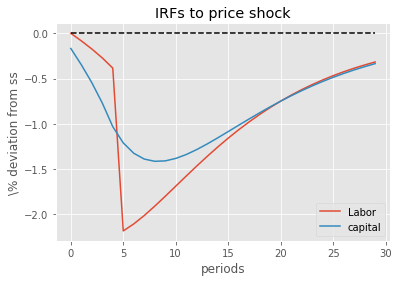

In [4]:
Time = 300     
# ttt = np.arange(0,Time)
ann = 5
dp = np.zeros(Time)
dp[ann:] = - 0.01  * 0.9**(np.arange(Time-ann))
J      = Firm_prop_simple_het.jac(ss, Time, ['p'])  # get jacobian    

dL = J['L']['p'] @ dp * 100 / ss['L']
dK = J['K']['p'] @ dp * 100 / ss['K']

plt.plot(dL[:30], label='Labor')
plt.plot(dK[:30], label='capital')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('IRFs to price shock')
plt.ylabel(r'\% deviation from ss')
plt.xlabel(r'periods')
plt.legend()
plt.show() 

## Comparison

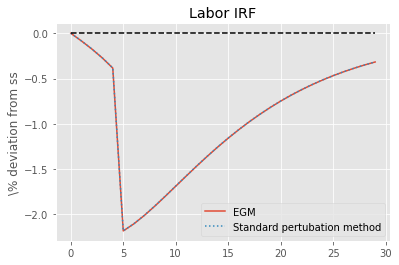

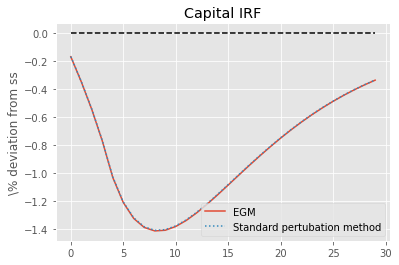

In [5]:
# Since there is no heterogeneity in the above model we can compare the solution to the one obtained 
# from a simple model solved using either standard pertubation methods (first-order approx. around steady-state as in dynare etc.)
# or compute full non-linear solution using a newton-solver.
# The solution using EGM and either of these methods should be identical (if grids for EGM are dense enough)

from solved_block import solved

# define block with equations
@solved(unknowns=['L', 'K'], targets=['L_res', 'K_res'])
def firm_block(alphaK, alphaL, interest, p, w, pI, Z, gamma, L, K, deltaK):
    beta = 1 /(1+interest)
    L_res = alphaL*p*Z*K(-1)**(alphaK)*L**(alphaL-1) - w 
    dfgamma1 = gamma * (K/K(-1)-1) 
    dfgamma2 = gamma /2 * ((K(+1)/K)**2 -1)
    MPK_P = Z(+1) * p(+1) * alphaK*K**(alphaK-1)*L(+1)**(alphaL)
    K_res = p * dfgamma1 + pI - beta * (pI(+1)*(1-deltaK) +  MPK_P + p(+1) * dfgamma2)
    Y = Z * K**alphaK * L**alphaL
    return K_res, L_res, Y

ss.update({'Z':1})
J_simple =   firm_block.jac(ss, Time, ['p'])     

dL_simple = J_simple['L']['p'] @ dp * 100 / ss['L']
dK_simple   = J_simple['K']['p'] @ dp * 100 / ss['K']

plt.plot(dL[:30], label='EGM')
plt.plot(dL_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Labor IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

plt.plot(dK[:30], label='EGM')
plt.plot(dK_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Capital IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

### They coincide! hurray!

# With zero profit constraint

In [12]:
from consav import golden_section_search
from numba import njit
@njit
def profitfunc(k, z, k_grid, l, alphaK, alphaL, p, pI, w, gamma, deltaK):
    N = z * k_grid**alphaK * l**alphaL - EGM_utils.get_gamma_derive(k, k_grid, gamma)[0] 
    i = k - (1-deltaK) * k_grid
    profit = p * N - w * l - pI * i
    return -profit # golden search minimizes  

@het(exogenous='Pi_p', policy=['k'], backward=['mCont_val'])
def Firm_prop_simple_zero_profitcon(mCont_val_p, Pi_p, k_grid, z_grid, alphaK, alphaL, p, deltaK, gamma, w, pI, interest):
    """Single backward iteration step using endogenous gridpoint method"""
    z = z_grid
    beta = 1/(1+interest)
    
    dfgamma1 = EGM_utils.get_gamma_derive(k_grid[:, np.newaxis], k_grid[np.newaxis, :], gamma)[1] 
    
    # take expectation over future marginal continuation value
    E_mCont_val = beta * EGM_utils.matrix_times_first_dim(Pi_p, mCont_val_p) 
    
    # solve for todays capital input using dynamic FOC using interpolation (i.e. interpolate such that rhs = lhs)
    rhs = E_mCont_val
    lhs = pI + p * dfgamma1
    i, pi = EGM_utils.lhs_equals_rhs_interpolate(rhs, lhs)
    k = utils.apply_coord(i, pi, k_grid)  
    # calculate l and y 
    l = EGM_utils.inv_L_demand(w, alphaL, alphaK, z[:, np.newaxis], k_grid[np.newaxis, :], p)
    y = z[:, np.newaxis] * l**alphaK * k_grid[np.newaxis, :]**alphaK 
    profit = -profitfunc(k, z[:, np.newaxis], k_grid[np.newaxis, :], l, alphaK, alphaL, p, pI, w, gamma, deltaK)
    
    # for choices of which imply non-positive profits we maximize profits using golden search 
    for jz in range(len(z)):
        for jk in range(len(k_grid)):
            if profit[jz,jk] <= 0: 
                args = (z[jz], k_grid[jk], l[jz,jk], alphaK, alphaL, p, pI, w, gamma, deltaK)
                k[jz,jk] = golden_section_search.optimizer(profitfunc,k_grid[0],max(k_grid),args=args,tol=1e-06)
    profit = -profitfunc(k, z[:, np.newaxis], k_grid[np.newaxis, :], l, alphaK, alphaL, p, pI, w, gamma, deltaK)
    assert profit.all() > 0 
    
    # calculate marginal continuation value for further backwards iteration 
    dfgamma2 = EGM_utils.get_gamma_derive(k, k_grid[np.newaxis, :], gamma)[2]
    MPK = p * alphaK * z[:, np.newaxis] * k_grid[np.newaxis, :]**(alphaK-1) * l**alphaL
    mCont_val = pI * (1-deltaK) + p * dfgamma2 + MPK
    return k, l, y, mCont_val, profit

# iterate until steady state is reached 
Firm_prop_simple_profitcon= Firm_prop_simple_zero_profitcon.attach_hetinput(EGM_utils.HET_add_ons)
ss_profitcon = Firm_prop_simple_profitcon.ss(**pars, accelerated_it = False, noisy=True)


Iteration: 0
Iteration: 100
Converged after : 101 iterations
